# Learning from Irregularly-Sampled Time Series: A Missing Data Perspective

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader

from gen_toy_data import HomogeneousPoissonProcess
from vis import plot_samples
from time_series import TimeSeries
from utils import Rescaler, make_scheduler
from spline_cconv import ContinuousConv1D
from layers import Decoder, gan_loss
from toy_pvae import Encoder as PVAE_Encoder
from toy_pbigan import Encoder as PBiGAN_Encoder
from toy_pbigan import ConvCritic
from mmd import mmd
from toy_layers import SeqGeneratorDiscrete

In [3]:
use_cuda = torch.cuda.is_available()
device = torch.device('cuda' if use_cuda else 'cpu')

## Creating multivariate time series data

We generate a dataset of 10,000 time series, each of which has three channels 
over $t\in[0, 1]$ based on the following generative process:

$$
\begin{align*}
  a &\sim \mathcal{N}(0, 10^2) \\
  b &\sim \operatorname{uniform}(0, 10) \\
  f_1(t) &= 0.8\sin(20(t + a) + \sin(20(t + a))) \\
  f_2(t) &= -0.5\sin(20(t + a + 20) + \sin(20(t + a + 20))) \\
  f_3(t) &= \sin(12(t + b))
\end{align*}
$$

where an independent Gaussian noise $\mathcal{N}(0, 0.01^2)$ is added
to each channel.

The observation time points for each channel are drawn independently
from a homogeneous Poisson process with rate $\lambda=50$
sampled sequentially in the range $[d, d+0.25]$
with $d\sim\operatorname{uniform}(0,0.75)$.

In [4]:
def gen_data(n_samples=10000, seq_len=200, max_time=1, poisson_rate=50,
             obs_span_rate=.25):
    """Generates a 3-channel synthetic dataset.

    The observations are within a window of size (max_time * obs_span_rate)
    randomly occurring at the time span [0, max_time].

    Args:
        n_samples:
            Number of data cases.
        seq_len:
            Maximum number of observations in a channel.
        max_time:
            Length of time interval [0, max_time].
        poisson_rate:
            Rate of homogeneous Poisson process.
        obs_span_rate:
            The continuous portion of the time span [0, max_time]
            that observations are restricted in.
    """
    n_channels = 3
    time_unif = np.linspace(0, max_time, seq_len)
    time_unif_3ch = np.broadcast_to(time_unif, (n_channels, seq_len))
    data_unif = np.empty((n_samples, n_channels, seq_len))
    sparse_data, sparse_time, sparse_mask = [
        np.empty((n_samples, n_channels, seq_len)) for _ in range(3)]
    tpp = HomogeneousPoissonProcess(rate=poisson_rate)

    def gen_time_series(offset1, offset2, t):
        t1 = t[0] + offset1
        t2 = t[2] + offset2
        t1_shift = t[1] + offset1 + 20
        data = np.empty((3, seq_len))
        data[0] = np.sin(t1 * 20 + np.sin(t1 * 20)) * .8
        data[1] = -np.sin(t1_shift * 20 + np.sin(t1_shift * 20)) * .5
        data[2] = np.sin(t2 * 12)
        return data

    for i in range(n_samples):
        offset1 = np.random.normal(0, 10)
        offset2 = np.random.uniform(0, 10)

        # Noise-free evenly-sampled time series
        data_unif[i] = gen_time_series(offset1, offset2, time_unif_3ch)

        # Generate observations between [0, obs_span_rate].
        times, masks = tpp.sample(3, seq_len, max_time=obs_span_rate)
        # Add independent random offset Unif(0, 1 - obs_span_rate) to each
        # channel so that all the observations will still be within [0, 1].
        times += torch.rand((3, 1)) * (1 - obs_span_rate)
        # Scale time span from [0, 1] to [0, max_time].
        times *= max_time
        # Set time entries corresponding to unobserved samples to time 0.
        sparse_time[i] = times * masks
        sparse_mask[i] = masks
        sparse_data[i] = gen_time_series(offset1, offset2, times)

    # Add a small independent Gaussian noise to each channel
    sparse_data += np.random.normal(0, .01, sparse_data.shape)

    # Pack the data to minimize the padded entries
    compact_len = sparse_mask.astype(int).sum(axis=2).max()
    compact_data, compact_time, compact_mask = [
        np.zeros((n_samples, 3, compact_len)) for _ in range(3)]
    for i in range(n_samples):
        for j in range(3):
            idx = sparse_mask[i, j] == 1
            n_obs = idx.sum()
            compact_data[i, j, :n_obs] = sparse_data[i, j, idx]
            compact_time[i, j, :n_obs] = sparse_time[i, j, idx]
            compact_mask[i, j, :n_obs] = sparse_mask[i, j, idx]

    return compact_data, compact_time, compact_mask, data_unif, time_unif

In [5]:
train_data, train_time, train_mask, data_unif, time_unif = gen_data(
    n_samples=10000, seq_len=200, max_time=1, poisson_rate=50,
    obs_span_rate=.25)

### Plotting the generated time series

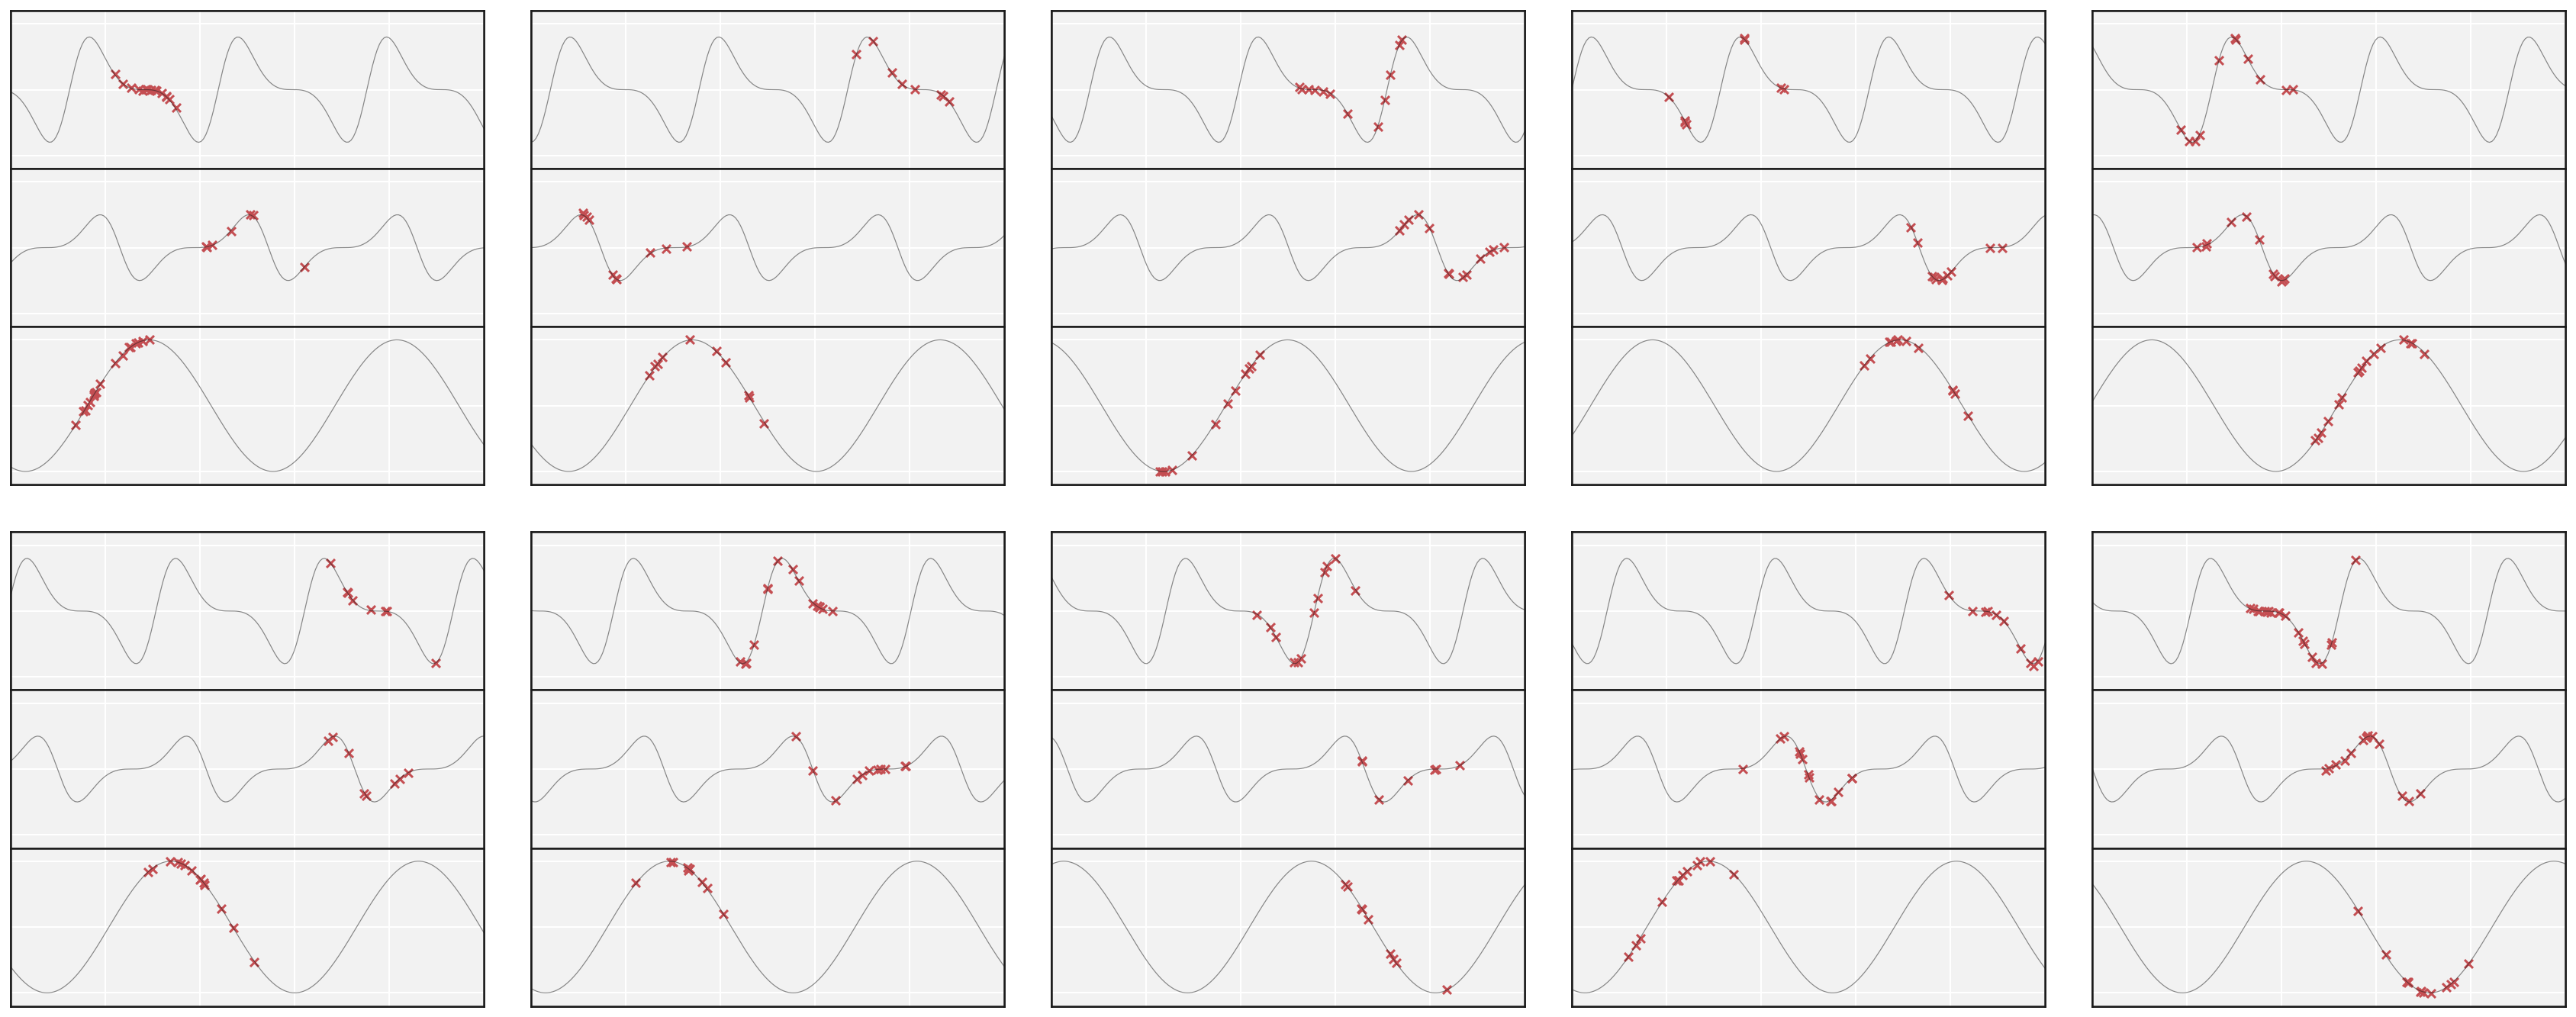

In [6]:
plot_samples(data_unif, np.broadcast_to(time_unif, data_unif.shape),
             train_data, train_time, train_mask, ncols=5)

## Data preprocessing

The observed values of the time series are rescaled to [−1, 1] according to the minimum and
maximum value of each channel across the entire dataset.

In [7]:
_, in_channels, seq_len = train_data.shape

# Optional: Scaling train_time works better with current hyperparameters.
max_time = 5
scaled_train_time = train_time * max_time

rescaler = Rescaler(train_data)
scaled_train_data = rescaler.rescale(train_data)

### Function for plotting the imputed/generated time series of the model

In [8]:
def plot_results(encoder, decoder, batch_size, max_time,
                 train_dataset, rescaler):
    test_loader = DataLoader(train_dataset, batch_size=batch_size,
                             collate_fn=train_dataset.collate_fn)
    (val, idx, mask, _, cconv_graph) = next(iter(test_loader))
    in_channels = val.shape[1]
    t = torch.linspace(0, max_time, 200, device=device)
    t = t.expand(batch_size, in_channels, len(t)).contiguous()
    t_mask = torch.ones_like(t)

    encoder.eval()
    decoder.eval()
    with torch.no_grad():
        z = encoder(cconv_graph, batch_size)
        if not torch.is_tensor(z):   # P-VAE encoder returns a list
            z = z[0]
        imp_data = decoder(z, t, t_mask)
        print('imputation:')
        plot_samples(imp_data, t,
                     val, idx, mask,
                     rescaler=rescaler,
                     max_time=max_time,
                     nrows=1, ncols=5)
        plt.show()

        data_noise = torch.empty_like(z).normal_()
        gen_data = decoder(data_noise, t, t_mask)
        print('generation:')
        plot_samples(gen_data, t,
                     rescaler=rescaler,
                     max_time=max_time,
                     nrows=1, ncols=5)
        plt.show()

## Partial Variational Autoencoder (P-VAE)

<img src="figures/pvae.png" width="100" style="display: block; margin: 2em auto" />

The training objective of P-VAE is given by

$$
\max_{\theta,\phi}\mathbb{E}_{(\mathbf{x},\mathbf{t})\sim p_\mathcal{D}}
\mathbb{E}_{\mathbf{z}\sim q_\phi(\mathbf{z}|\mathbf{x},\mathbf{t})}\left[
\log \frac{p_z(\mathbf{z}) \prod_{i=1}^{|\mathbf{t}|} p_\theta(x_i|\mathbf{z},t_i)}
{q_\phi(\mathbf{z}|\mathbf{x},\mathbf{t})} \right]
$$
where 
* $q_\phi(\mathbf{z}|\mathbf{x},\mathbf{t})$: 
  stochastic encoder that models the posterior with parameters $\phi$
* $p_\theta(x_i|\mathbf{z},t_i) = \mathcal{N}(g_\theta(\mathbf{z},t_i), \sigma^2)$: 
  density of the decoded $\mathbf{z}$ at index $t_i$ 
  by the decoder $g_\theta$ parameterized by $\theta$
* $p_z(\mathbf{z})$: prior distribution $\mathcal{N}(\mathbf{0}, \mathbf{I})$
* $p_\mathcal{D}$: empirical distribution of the training data

In [9]:
class PVAE(nn.Module):
    def __init__(self, encoder, decoder, sigma=.2):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.sigma = sigma

    def forward(self, data, time, mask, cconv_graph):
        batch_size = len(data)
        z, mu, logvar, eps = self.encoder(cconv_graph, batch_size)
        x_recon = self.decoder(z, time, mask)
        recon_loss = (1 / (2 * self.sigma**2) * F.mse_loss(
            x_recon * mask, data * mask, reduction='none') * mask).sum((1, 2))
        kl_loss = .5 * (z**2 - logvar - eps**2).sum(1)
        loss = recon_loss.mean() + kl_loss.mean()
        return loss

### Training P-VAE

In [10]:
# Hyperparameters for training P-VAE
batch_size = 128
latent_size = 32
epochs = 1000
lr = 1e-4
min_lr = 5e-5
sigma = .2

train_dataset = TimeSeries(
    scaled_train_data, scaled_train_time, train_mask, max_time=max_time,
    device=device)

train_loader = DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True,
    drop_last=True, collate_fn=train_dataset.collate_fn)

grid_decoder = SeqGeneratorDiscrete(in_channels, latent_size, torch.tanh)
decoder = Decoder(grid_decoder, max_time=max_time).to(device)

cconv = ContinuousConv1D(in_channels, max_time=max_time, norm=True).to(device)
encoder = PVAE_Encoder(latent_size, cconv).to(device)

pvae = PVAE(encoder, decoder, sigma=sigma).to(device)

optimizer = optim.Adam(pvae.parameters(), lr=lr)
scheduler = make_scheduler(optimizer, lr, min_lr, epochs)

for epoch in range(epochs):
    for val, idx, mask, _, cconv_graph in train_loader:
        optimizer.zero_grad()
        loss = pvae(val, idx, mask, cconv_graph)
        loss.backward()
        optimizer.step()

    if scheduler:
        scheduler.step()

### P-VAE results

imputation:


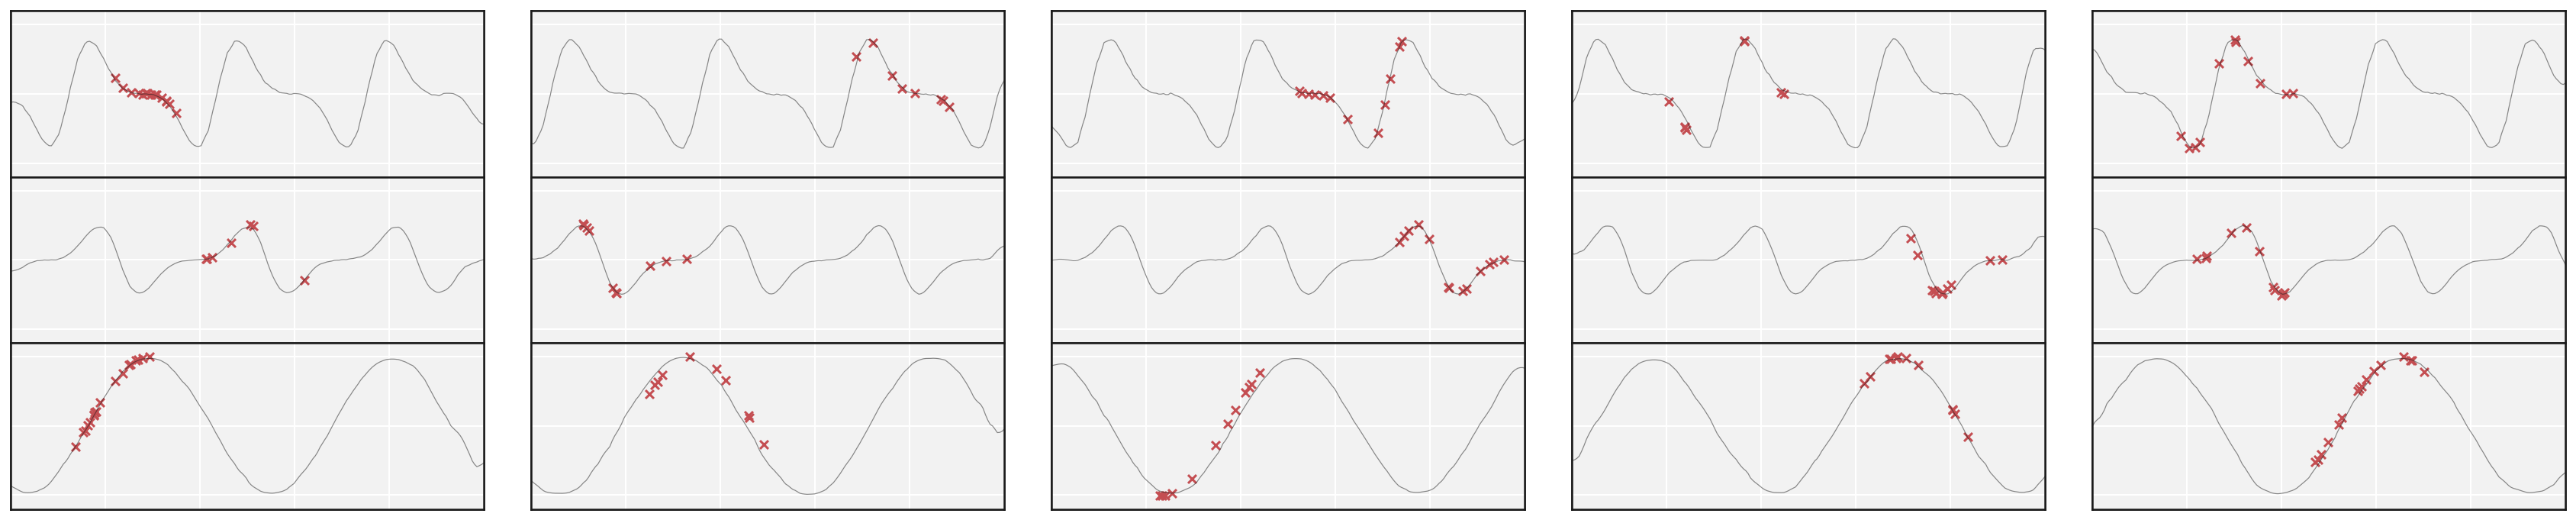

generation:


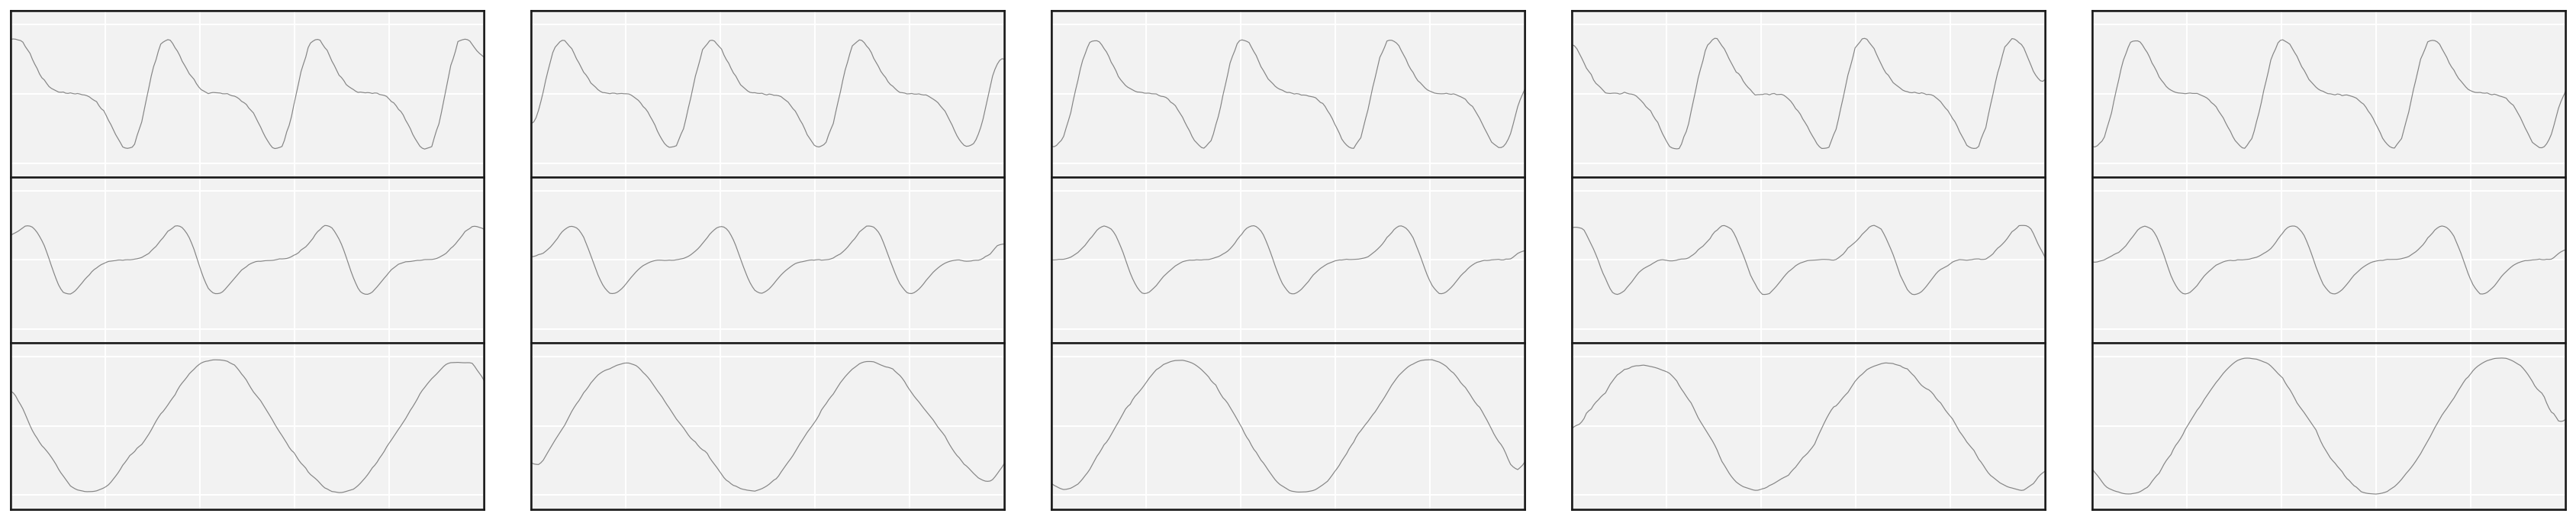

In [11]:
plot_results(pvae.encoder, pvae.decoder, batch_size, max_time,
             train_dataset, rescaler)

## Partial Bidirectional GAN (P-BiGAN)

<img src="figures/pbigan.png" width="300" style="display: block; margin: 2em auto" />

The overall training objective of P-BiGAN is composed of three parts: 
a minimax GAN objective, an MMD loss, and a autoencoding loss.
The specific form is given by

$$
\begin{align*}
&\min_{\theta,\phi}\Big\{\max_{D_{xz}, D_{x}}
  \mathbb{E}_{
    (\mathbf{x},\mathbf{t})\sim p_\mathcal{D},\ 
    \mathbf{z}'\sim p_z
  }
  \mathbb{E}_{
    \mathbf{z}\sim p_\phi(\mathbf{z}|\mathbf{x},\mathbf{t}),\ 
    (\cdot,\mathbf{t}')\sim p_\mathcal{D}
  }\big[
    L_{\text{GAN}}(
      \mathbf{x},\mathbf{t},\mathbf{z}, 
      g_\theta(\mathbf{z}',\mathbf{t}'),\mathbf{t}',\mathbf{z}')
  \big] 
  \Big\}
  \\
  &\qquad
  + 
  \gamma
  L_{\text{MMD}}\left(
    \{\mathbf{z}_i\sim p_\phi(\mathbf{z}|\mathbf{x}_i,\mathbf{t}_i)\mid 
      (\mathbf{x}_i,\mathbf{t}_i)\sim p_\mathcal{D}\}_{i=1}^m, 
    \{\mathbf{z}'_i\sim p_z\}_{i=1}^m
  \right)
  \\
  &\qquad
  + 
  \lambda
  \mathbb{E}_{\mathbf{z}\sim q_\phi(\mathbf{z}|\mathbf{x},\mathbf{t})}\bigg[
  \sum_{i=1}^{|\mathbf{t}|} \ell\left(x_i, g_\theta(\mathbf{z},t_i)\right)\bigg].
\end{align*}
$$

The first two parts are similar to the loss of [BigBiGAN](https://arxiv.org/abs/1907.02544),
except that the discriminator for the latent code is replaced by an MMD loss, which
requires no extra training.
We apply the GAN loss to both the incomplete data $(\mathbf{x},\mathbf{t})$ alone and
the joint of incomplete data and the corresponding latent code $\mathbf{z}$ as shown below:

$$
\begin{align*}
L_{\text{GAN}}(
  \mathbf{x},\mathbf{t},\mathbf{z},
  \mathbf{x}',\mathbf{t}',\mathbf{z}'
) 
&=
\big\{
\log D_{xz}(\mathbf{x},\mathbf{t},\mathbf{z}) 
- 
\log(1 - D_{xz}(\mathbf{x}',\mathbf{t}',\mathbf{z}'))
\big\} \\
&\quad +
\big\{
\log D_{x}(\mathbf{x},\mathbf{t}) 
- 
\log(1 - D_{x}(\mathbf{x}',\mathbf{t}'))
\big\}.
\end{align*}
$$

The MMD loss takes as input a collection of latent code drawn from the prior and
another collection of latent code drawn from the posterior: 

$$
L_{\text{MMD}}\left(\{\mathbf{z}\}_{i=1}^m, \{\mathbf{z}'\}_{i=1}^m\right)
=
\frac{1}{m(m-1)}\sum_{i \ne j} k(\mathbf{z}_i, \mathbf{z}_j)
+ 
\frac{1}{m(m-1)}\sum_{i \ne j} k(\mathbf{z}'_i, \mathbf{z}'_j)
-
\frac{2}{m^2}\sum_{i,j} k(\mathbf{z}_i, \mathbf{z}'_j).
$$

We use the inverse multiquadratic kernel below with the fixed hyperparameter
$C=2 d_z$ where $d_z$ is the dimensionality of the latent variable $\mathbf{z}$:
$$
k(\mathbf{z}, \mathbf{z}')
=\frac{C}{C + \|\mathbf{z}-\mathbf{z}'\|^2}.
$$

For the last term, the autoencoding loss, we use the
[smooth L1 loss](https://pytorch.org/docs/stable/nn.functional.html#smooth-l1-loss) 
for $\ell(\cdot, \cdot)$.

The two non-negative coefficients $\gamma$ and $\lambda$ control
the strength of the MMD loss and the autoencoding loss.

In [12]:
class PBiGAN(nn.Module):
    def __init__(self, encoder, decoder):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder

    def forward(self, data, time, mask, cconv_graph, time_t, mask_t):
        batch_size = len(data)
        z_T = self.encoder(cconv_graph, batch_size)
        z_gen = torch.empty_like(z_T).normal_()
        x_gen = self.decoder(z_gen, time_t, mask_t)
        x_recon = self.decoder(z_T, time, mask)
        ae_loss = F.smooth_l1_loss(x_recon, data, reduction='none') * mask
        ae_loss = ae_loss.sum((-1, -2))
        return z_T, x_recon, z_gen, x_gen, ae_loss.mean()

### Training P-BiGAN

In [13]:
# Hyperparameters for training P-BiGAN
epoch = 1000
latent_size = 32
batch_size = 128
lr = 8e-5
dis_lr = 1e-4
min_lr = 5e-5
min_dis_lr = 7e-5
ae = .2
mmd_w = 1

train_dataset = TimeSeries(
    scaled_train_data, scaled_train_time, train_mask, max_time=max_time,
    device=device)

train_loader = DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True,
    drop_last=True, collate_fn=train_dataset.collate_fn)

time_loader = DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True,
    drop_last=True, collate_fn=train_dataset.collate_fn)

grid_decoder = SeqGeneratorDiscrete(in_channels, latent_size, torch.tanh)
decoder = Decoder(grid_decoder, max_time=max_time).to(device)

cconv = ContinuousConv1D(in_channels, max_time=max_time, norm=True).to(device)
encoder = PBiGAN_Encoder(cconv, latent_size).to(device)

pbigan = PBiGAN(encoder, decoder).to(device)

critic_cconv = ContinuousConv1D(
    in_channels, max_time=max_time, norm=True).to(device)
critic = ConvCritic(critic_cconv, latent_size).to(device)

optimizer = optim.Adam(pbigan.parameters(), lr=lr)
critic_optimizer = optim.Adam(critic.parameters(), lr=dis_lr)

scheduler = make_scheduler(optimizer, lr, min_lr, epochs)
dis_scheduler = make_scheduler(
    critic_optimizer, dis_lr, min_dis_lr, epochs)

for epoch in range(epochs):
    for ((val, idx, mask, _, cconv_graph),
         (_, idx_t, mask_t, index, _)) in zip(
             train_loader, time_loader):

        z_enc, x_recon, z_gen, x_gen, ae_loss = pbigan(
            val, idx, mask, cconv_graph, idx_t, mask_t)

        cconv_graph_gen = train_dataset.make_graph(
            x_gen, idx_t, mask_t, index)

        real = critic(cconv_graph, batch_size, z_enc)
        fake = critic(cconv_graph_gen, batch_size, z_gen)

        D_loss = gan_loss(real, fake, 1, 0)

        critic_optimizer.zero_grad()
        D_loss.backward(retain_graph=True)
        critic_optimizer.step()

        G_loss = gan_loss(real, fake, 0, 1)
        mmd_loss = mmd(z_enc, z_gen)
        loss = G_loss + ae_loss * ae + mmd_loss * mmd_w

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    if scheduler:
        scheduler.step()
    if dis_scheduler:
        dis_scheduler.step()

### P-BiGAN results

imputation:


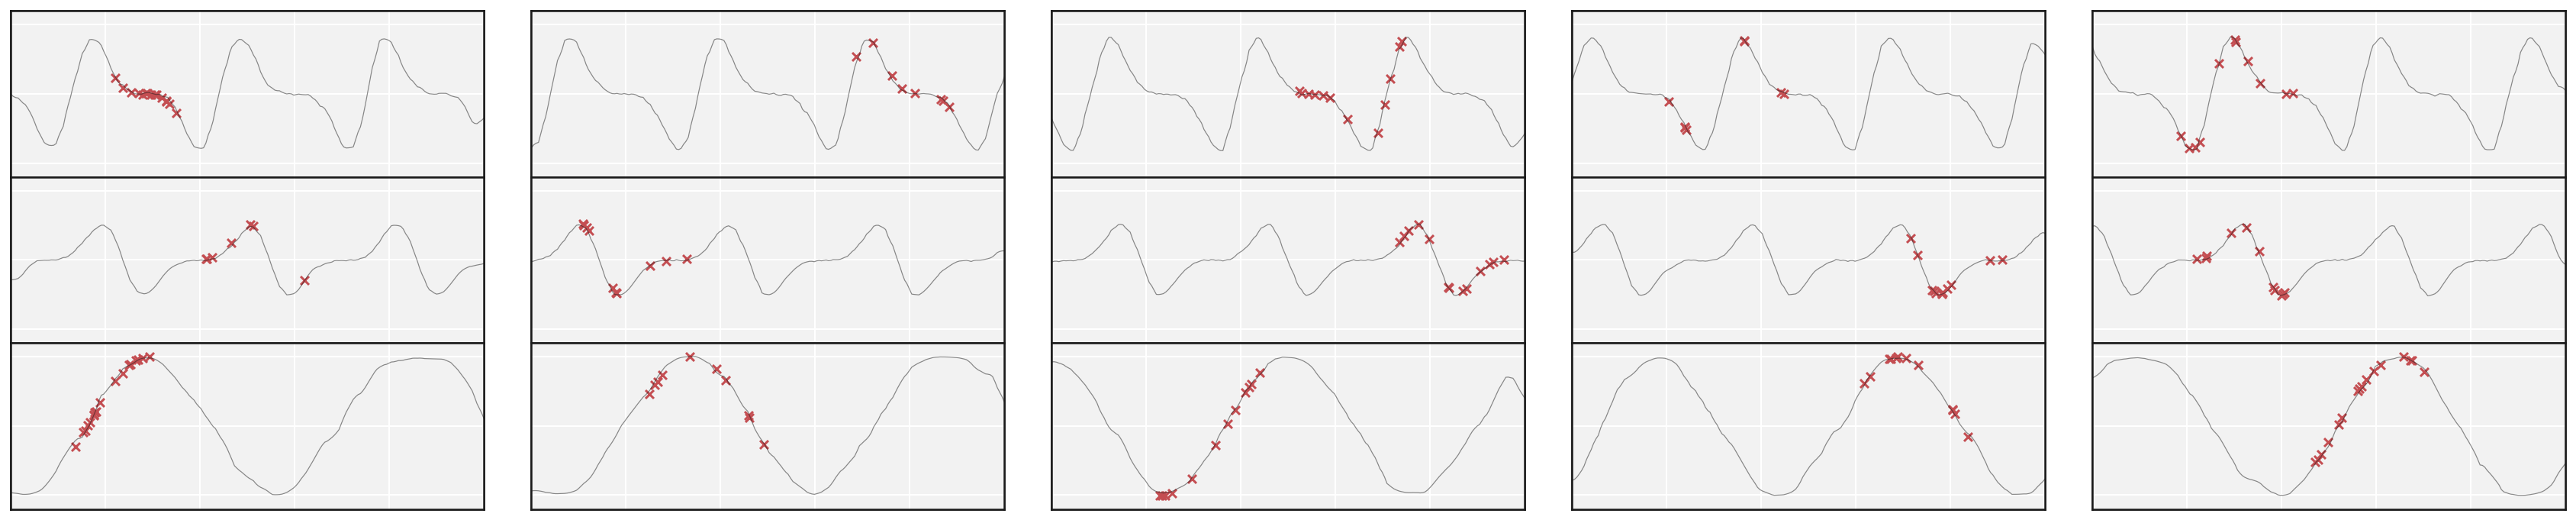

generation:


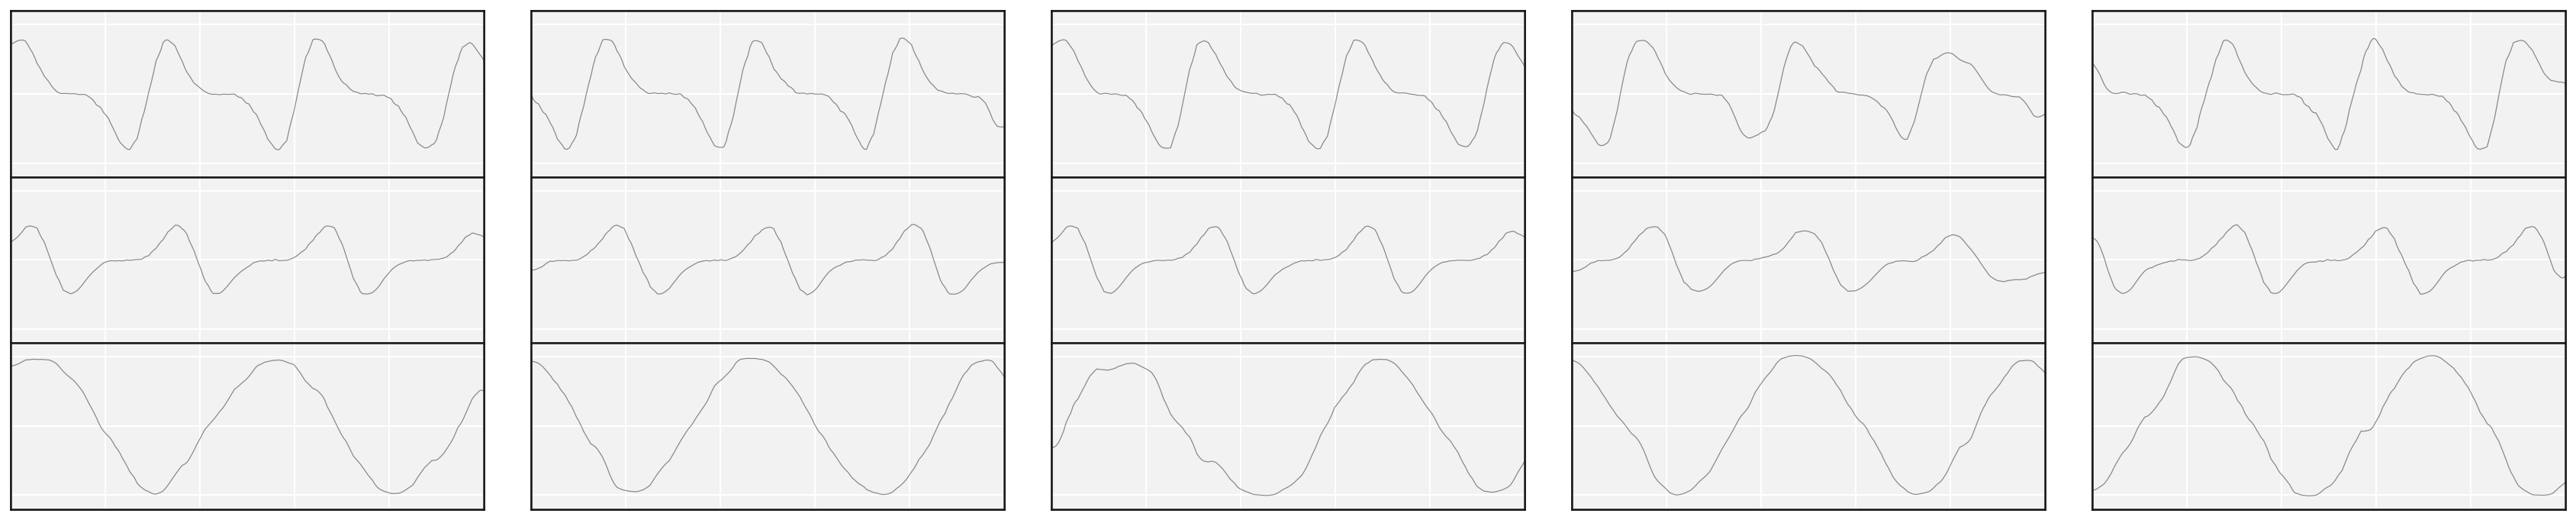

In [14]:
plot_results(pbigan.encoder, pbigan.decoder, batch_size, max_time,
             train_dataset, rescaler)